In [2]:
#Libraries
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [3]:
#Take the fits file to pandas for the analysis code, we only use the mu=1 data
with fits.open(r"C:\Users\clauw\Documents\Programming\Final-Project\Spatial range\solarspectrum_mu1.fits") as hdul:
    tabla = hdul[0].data

table = pd.DataFrame(tabla)

In [4]:
#Create the dataframe of raw data
raw_data = pd.DataFrame()
raw_data['Wave A'] = np.array(table.iloc[0].tolist())
raw_data['nFlux'] = np.array(table.iloc[1].tolist())
raw_data


,Wave A,nFlux
0,4200.000,0.873086
1,4200.001,0.875943
2,4200.002,0.879616
3,4200.003,0.884252
4,4200.004,0.887163
...,...,...
3799996,7999.996,0.974642
3799997,7999.997,0.974583
3799998,7999.998,0.974533
3799999,7999.999,0.974483


In [5]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Visible range\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
614,10425.8870
615,10426.6020
616,10535.1220
617,10580.0390


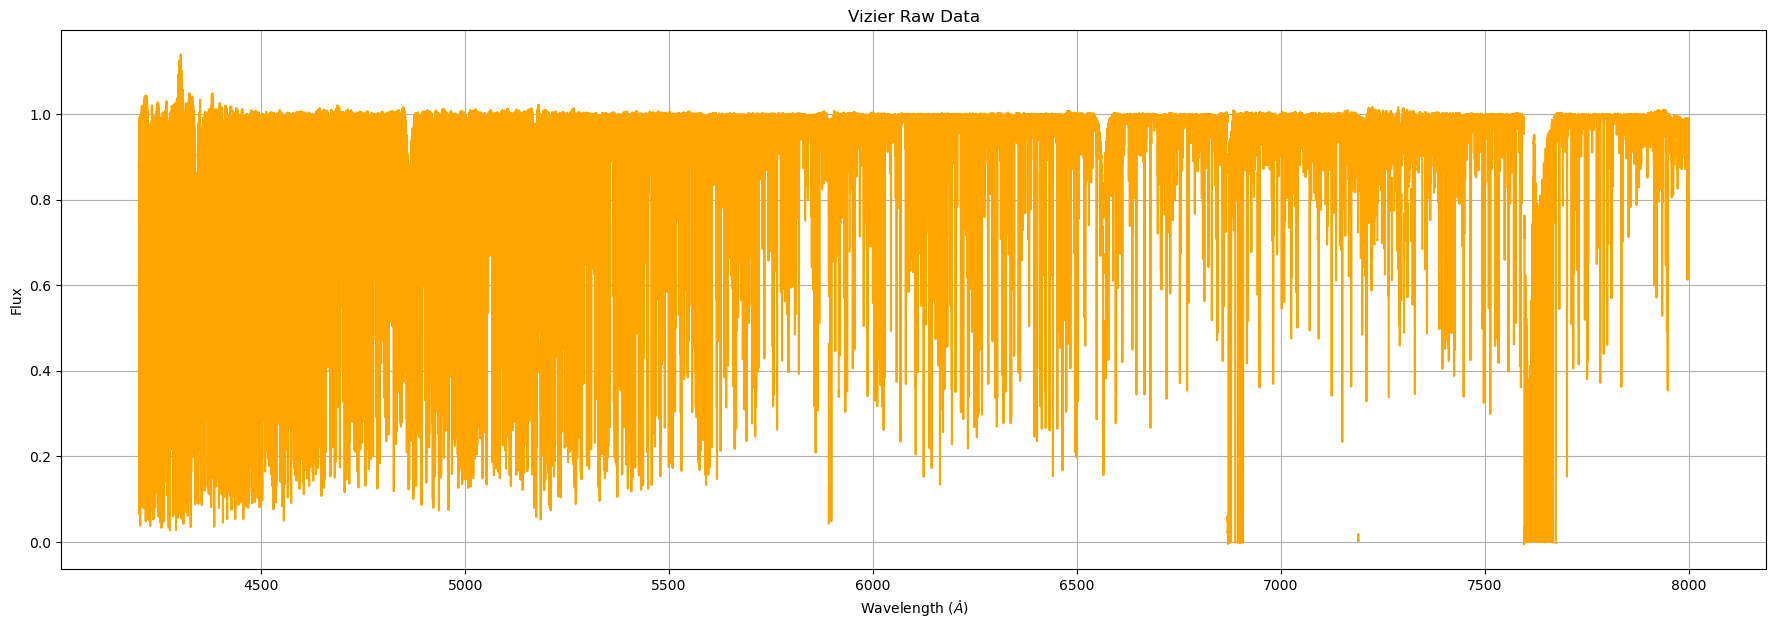

In [6]:
#Plot of raw data
fig, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(raw_data['Wave A'],raw_data['nFlux'], color='orange')
ax.set_title('Vizier Raw Data')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

### Wavelength classification

In [7]:
#Between work like < or > but not the equal, reset the index for the other functions
data_4000_5000 = raw_data[raw_data['Wave A'].between(4000, 5000, inclusive='neither')].reset_index(drop=True)
data_5000_6000 = raw_data[raw_data['Wave A'].between(5000, 6000, inclusive='neither')].reset_index(drop=True)
data_6000_7000 = raw_data[raw_data['Wave A'].between(6000, 7000, inclusive='neither')].reset_index(drop=True)
data_7000_8000 = raw_data[raw_data['Wave A'].between(7000, 8000, inclusive='neither')].reset_index(drop=True)

data_5000_6000

,Wave A,nFlux
0,5000.001,0.990062
1,5000.002,0.990149
2,5000.003,0.990468
3,5000.004,0.990989
4,5000.005,0.991496
...,...,...
999994,5999.995,0.987998
999995,5999.996,0.988049
999996,5999.997,0.988010
999997,5999.998,0.987693


In [8]:
#Now from lambda
lambda_4000_5000 = raw_lambda[raw_lambda['Nave list'].between(4000, 5000, inclusive='neither')].reset_index(drop=True)
lambda_5000_6000 = raw_lambda[raw_lambda['Nave list'].between(5000, 6000, inclusive='neither')].reset_index(drop=True)
lambda_6000_7000 = raw_lambda[raw_lambda['Nave list'].between(6000, 7000, inclusive='neither')].reset_index(drop=True)
lambda_7000_8000 = raw_lambda[raw_lambda['Nave list'].between(7000, 8000, inclusive='neither')].reset_index(drop=True)

lambda_4000_5000

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
141,4986.9382
142,4987.6138
143,4990.3419
144,4992.6608


### Find the minimums and the closer line of the Fe I line


In [9]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda
    closer_data = closer_data[closer_data['abs'] <= 0.025].reset_index(drop=True)

    return closer_data.drop(['abs'],axis=1)

closer_lines_4000_5000= find_minimums(data_4000_5000['Wave A'],data_4000_5000['nFlux'],lambda_4000_5000['Nave list'])
closer_lines_5000_6000 = find_minimums(data_5000_6000['Wave A'],data_5000_6000['nFlux'],lambda_5000_6000['Nave list'])
closer_lines_6000_7000 = find_minimums(data_6000_7000['Wave A'],data_6000_7000['nFlux'],lambda_6000_7000['Nave list'])
closer_lines_7000_8000 = find_minimums(data_7000_8000['Wave A'],data_7000_8000['nFlux'],lambda_7000_8000['Nave list'])


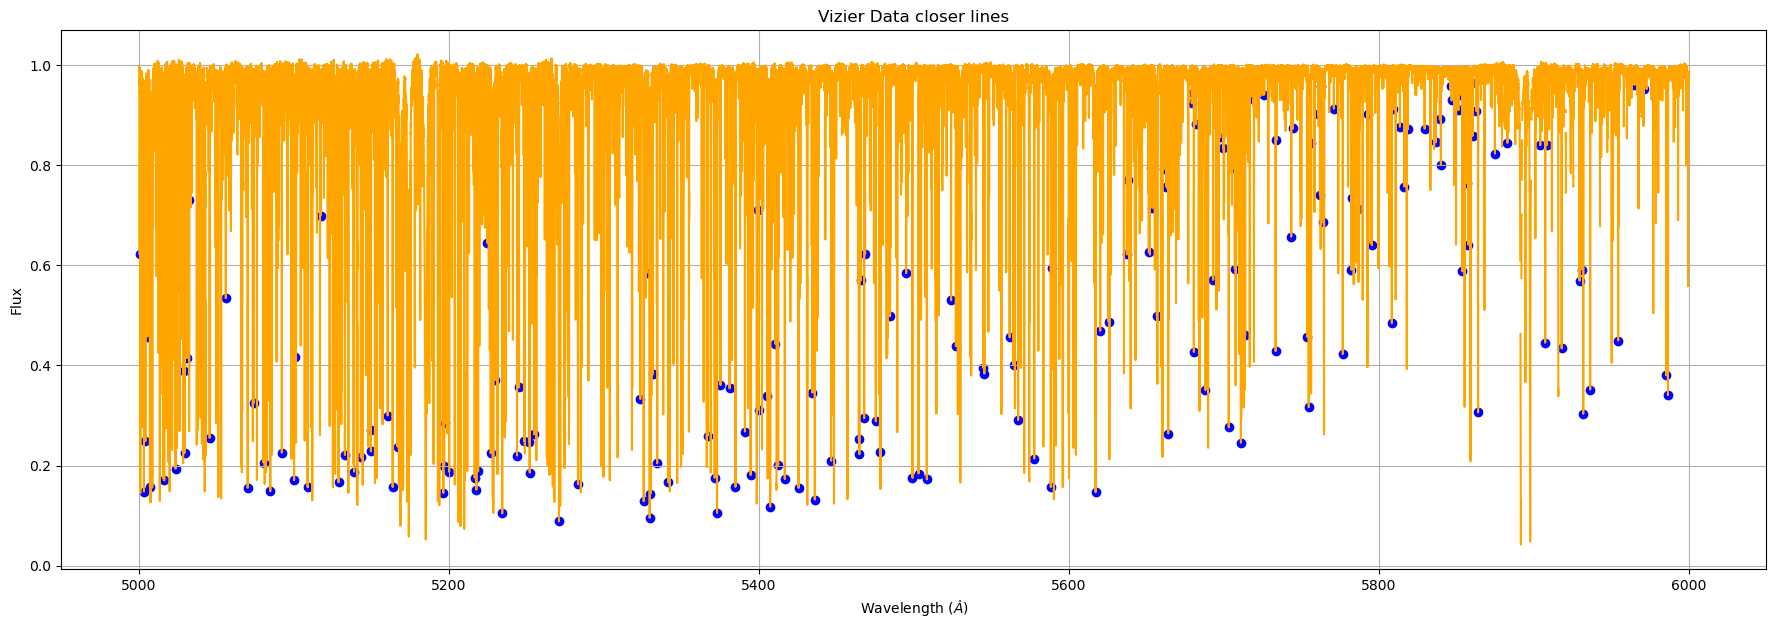

In [10]:
#Plot the identified lines
fig3, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_5000_6000['Wave A'],data_5000_6000['nFlux'], color='orange')
ax.scatter(closer_lines_5000_6000['min_wave'],closer_lines_5000_6000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [11]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points


local_points_4000_5000 = width_minimums(closer_lines_4000_5000,data_4000_5000,0.05)
local_points_5000_6000 = width_minimums(closer_lines_5000_6000,data_5000_6000,0.05)
local_points_6000_7000 = width_minimums(closer_lines_6000_7000,data_6000_7000,0.05)
local_points_7000_8000 = width_minimums(closer_lines_7000_8000,data_7000_8000,0.05)

### Derivates and fit

In [12]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))

            #Evaluate the second and third derivate in the wavelength observed
            d2 = poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2) #Re-scalated the coefficients
            d3 = Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) ) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, second derivate, third derivate, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3,blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","2nd Derivate","3rd Derivate","Blueshift"]

    return Values

Values_4000_5000 = Fit_derivates(local_points_4000_5000,closer_lines_4000_5000['Fe line'])
Values_5000_6000 = Fit_derivates(local_points_5000_6000,closer_lines_5000_6000['Fe line'])
Values_6000_7000 = Fit_derivates(local_points_6000_7000,closer_lines_6000_7000['Fe line'])
Values_7000_8000 = Fit_derivates(local_points_7000_8000,closer_lines_7000_8000['Fe line'])
Values_4000_5000


,Emitted wavelength,Observed wavelength,Flux,Velocity,2nd Derivate,3rd Derivate,Blueshift
0,4202.1078,4202.1137,0.120261,-212,450.608527,-0.007901,420.925780
1,4203.9370,4203.9391,0.251287,-483,762.620438,-0.000098,149.755851
2,4206.7233,4206.7272,0.169646,-355,539.903829,-0.004571,277.933799
3,4208.3123,4208.3170,0.111958,-298,569.211042,-0.003034,334.819389
4,4209.7896,4209.7963,0.124643,-156,440.141820,-0.015964,477.128232
...,...,...,...,...,...,...,...
114,4986.9382,4985.3900,-308.649324,-93704,1820.445963,0.000508,-93070.871316
115,4987.6138,4987.6176,0.453740,-405,505.044951,-0.000640,228.408090
116,4990.3419,4990.3485,0.221842,-237,447.559653,-0.003874,396.491916
117,4992.6608,4992.6675,0.227579,-231,438.728235,-0.003798,402.312424


In [13]:
Values = pd.concat([Values_4000_5000, Values_5000_6000, Values_6000_7000, Values_7000_8000],axis=0).reset_index(drop=True)
Values = Values[Values['Flux']>0]

In [14]:
#Separate for color range, making a listfor the plot

values_colors = [ Values[Values["Observed wavelength"].between(3800, 4270, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(4270, 4760, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(4760, 4970, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(4970, 5700, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(5700, 5810, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(5810, 6180, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(6180, 7800, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(7800, 11000, inclusive='neither')]]

In [ ]:
# #Convert to excel
# Values.to_excel('values_SPA.xlsx', index=False)

## Graphics 

As we have an absorption spectrum, the line depth is measurement one minus the flux value.

In [16]:
#colors for the plot
colors = ['violet','blue','cyan','green','yellow','orange','red','brown']

### Velocity vs Normalized Flux

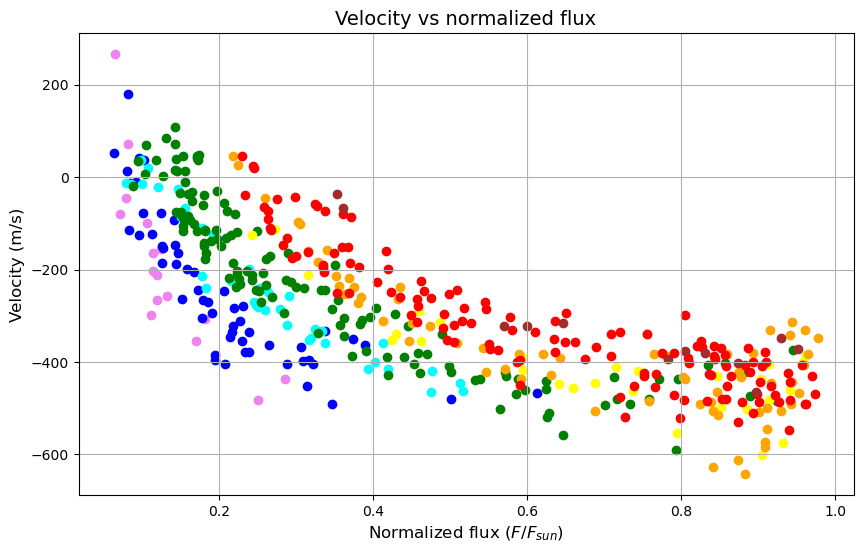

In [17]:
fig3, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['Velocity'], c=colors[i])

ax.set_title('Velocity vs normalized flux',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{sun})$', fontsize=12)
ax.set_ylabel('Velocity (m/s)', fontsize=12)
ax.grid()

# fig3.savefig('Velocity.png')

### Second Derivate vs Normalized Flux

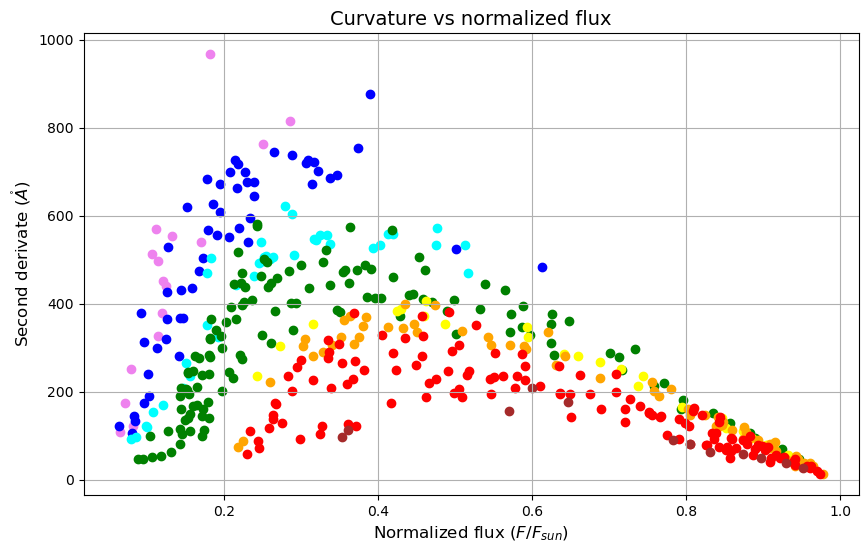

In [18]:
fig4, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['2nd Derivate'], color=colors[i])

ax.set_title('Curvature vs normalized flux',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Second derivate $(\mathring{A})$',fontsize=12)
ax.grid()

# fig4.savefig('Curvature.png')

### Third Derivate Expresion vs Normalized Flux

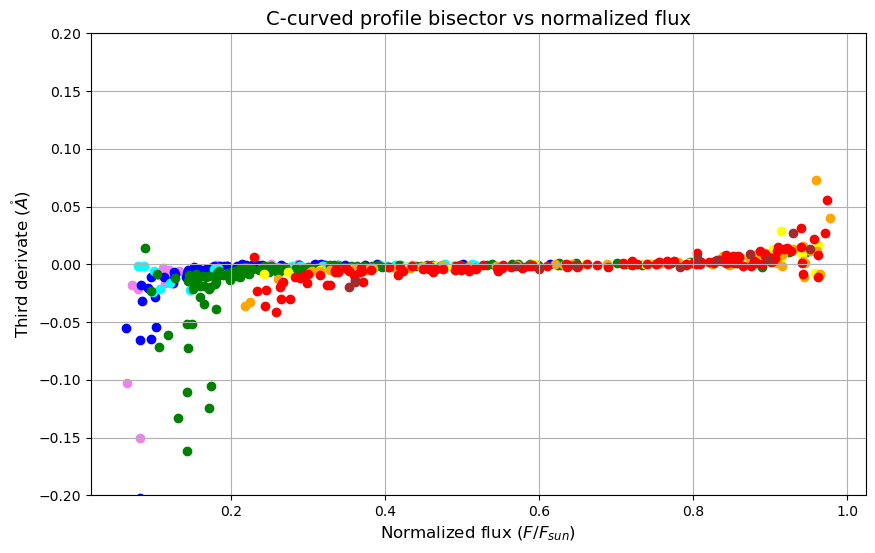

In [19]:
fig5, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['3rd Derivate'], color=colors[i])

ax.set_title('C-curved profile bisector vs normalized flux',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Third derivate $(\mathring{A})$',fontsize=12)
ax.set_ylim(-0.2,0.2)
ax.grid()

# fig5.savefig('CBisector.png')

### Convective Blueshift vs Line Depth

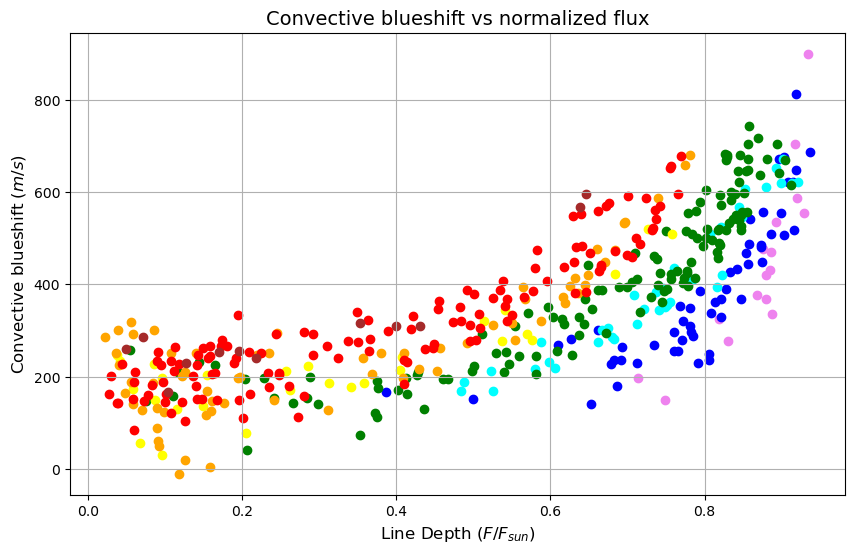

In [20]:
fig6, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(1-values_colors[i]['Flux'],values_colors[i]['Blueshift'], color=colors[i])

ax.set_title('Convective blueshift vs normalized flux',fontsize=14)
ax.set_xlabel(r'Line Depth $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Convective blueshift $(m/s)$',fontsize=12)
ax.grid()

# fig6.savefig('ConvectiveBlueshift.png')